# Logistic Regression Excercise 2

## Multi-class classification of MNIST using Logistic Regression

The multi-class scenario for logistic regression is quite similar to the binary case, except that the label $y$ is now an integer in {1, ...., K} where $K$ is the number of classes. In this excercise you will be provided with handwritten digit images. Write the code and compute the test accuracy by training a logistic regression based classifier in (i) one-vs-one, and (ii) one-vs-all setting.

In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        #print('searching: %s'%nb_path)
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        #print('searching: %s' % nb_path)
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        #print('Found %d cells'%len(nb.cells))
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


#  register the NotebookFinder with sys.meta_path
print('running importer')
sys.meta_path.append(NotebookFinder())

running importer


In [2]:
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
from itertools import combinations
from utils import plot_decision_boundary, get_accuracy, get_prediction
from utils import plot_2D_input_datapoints, generate_gifs, sigmoid, normalize
import math
import gif
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from utils.ipynb


In [3]:
# Let's initialize our weights using uniform distribution
def weight_init_uniform_dist(X, y):
  
    np.random.seed(312)
    n_samples, n_features = np.shape(X)
    _, n_outputs = np.shape(y)

    limit = 1 / math.sqrt(n_features)
    weights = np.random.uniform(-limit, limit, (n_features, n_outputs))
    weights[-1] = 0

    return weights

In [4]:
np.random.seed(12)

# One hot encoding of our output label vector y
def one_hot(a):
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size), a] = 1
    return b

# Loading dataset
digits = datasets.load_digits()

# One-hot encoding of target label, Y
Y = digits.target
Y = one_hot(Y)

# Absorbing weight b of the hyperplane
X = digits.data
b_ones = np.ones((len(X), 1))
X = np.hstack((X, b_ones))

<Figure size 432x288 with 0 Axes>

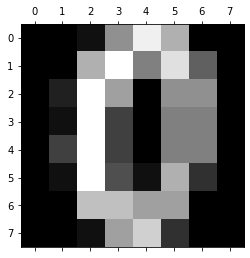

In [5]:
sns.reset_orig()

plt.gray()
plt.matshow(digits.images[10])
plt.show();

In [6]:
# Splitting dataset into train, val, and test set.
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, shuffle=True, test_size = 0.167)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.12517)

print("Training dataset: ", X_train.shape)
print("Validation dataset: ", X_val.shape)
print("Test dataset: ", X_test.shape)

Training dataset:  (1308, 65)
Validation dataset:  (188, 65)
Test dataset:  (301, 65)


In [7]:
# Normalizing X_train and absorbing weight b of the hyperplane
X_normalized_train = normalize(X_train[:, :64])

b_ones = np.ones((len(X_normalized_train), 1))
X_normalized_train = np.hstack((X_normalized_train, b_ones))

In [8]:
Y_train.shape

(1308, 10)

### Write your code below

In [9]:
# Let's initialize our weights using uniform distribution
def weight_init_uniform_dist(X, y):
  
    np.random.seed(312)
    n_samples, n_features = np.shape(X)
    _, n_outputs = np.shape(y)

    limit = 1 / math.sqrt(n_features)
    weights = np.random.uniform(-limit, limit, (n_features, n_outputs))
    weights[-1] = 0

    return weights

In [10]:
# Train on the dataset
def train_binary_classifier(X_train, Y_train, weights, num_epochs=1000, learning_rate=0.1):

    """ Method to train a logistic regression model.

    Parameters
    ------------

    X_train: ndarray (num_examples(rows) vs num_columns(columns))
    Input data on which the logistic regression model will be trained 
    to acquire optimal weights

    Y_train: ndarray (num_examples(rows) vs class_labels(columns))
    Class labels of training set

    weights: ndarray (num_features vs n_output)
    Weights used to train the network and predict on test set

    num_epochs: int
    Number of epochs you want to train the model

    learning_rate: int
    rate with which weights will be update every epoch.
    """

    n_samples, n_features = np.shape(X_train)
    _, n_outputs = np.shape(Y_train)

    history_weights = []
    epoch = 1

    # Training using Batch GD
    while epoch <= num_epochs:

        # Appending previous history weights/first initialized weights
        history_weights.append(weights)

        # Computing weighted inputs and predicting output
        w_transpose_x = np.dot(X_train, weights)
        y_pred = sigmoid(w_transpose_x)

        # Calculating gradient and updating weights
        gradient = 1 * np.dot(X_train.T, (Y_train - y_pred))
        weights += (learning_rate/n_samples) * gradient
        weights = np.round(weights, decimals=7)
        epoch += 1

    print("Training complete")

    return history_weights

In [11]:
# Initializing weights from uniform distribution
weights = weight_init_uniform_dist(X_normalized_train, Y_train)

In [12]:
# One vs One Classifier
classes=range(Y_train.shape[1])
a=[]
comb=combinations(classes, 2) #All possible one vs one classifier to be trained

for i in list(comb): 
    #Finding and removing the samples of class other than the pair i for training set
    print('For the class pair:',i[0],"&",i[1])
    binary_y_train= np.empty((Y_train.shape[0]))
    binary_y_val= np.empty((Y_val.shape[0]))
    binary_y_test= np.empty((Y_test.shape[0]))
    for j in range(Y_train.shape[0]):
        if Y_train[j,int(i[0])]==1:
            binary_y_train[j]=0
        elif Y_train[j,int(i[1])]==1:
            binary_y_train[j]=1
        else:
            binary_y_train[j]=-1
    other_class=np.argwhere(binary_y_train==-1)
    binary_y_train=np.delete(binary_y_train,other_class) 
    binary_y_train=np.reshape(binary_y_train,(-1,1))
    binary_Xnorm_train=np.delete(X_normalized_train,other_class,axis=0)
    binary_x_train=np.delete(X_train,other_class,axis=0)
    
    #Finding and removing the samples of class other than the pair i for training set
    for j in range(Y_val.shape[0]):
        if Y_val[j,int(i[0])]==1:
            binary_y_val[j]=0
        elif Y_train[j,int(i[1])]==1:
            binary_y_val[j]=1
        else:
            binary_y_val[j]=-1
    other_class=np.argwhere(binary_y_val==-1)
    binary_y_val=np.delete(binary_y_val,other_class) 
    binary_y_val=np.reshape(binary_y_val,(-1,1))
    binary_x_val=np.delete(X_val,other_class,axis=0)
    
    #Finding and removing the samples of class other than the pair i for test set
    for j in range(Y_test.shape[0]):
        if Y_test[j,int(i[0])]==1:
            binary_y_test[j]=0
        elif Y_test[j,int(i[1])]==1:
            binary_y_test[j]=1
        else:
            binary_y_test[j]=-1
    other_class=np.argwhere(binary_y_test==-1)
    binary_y_test=np.delete(binary_y_test,other_class) 
    binary_y_test=np.reshape(binary_y_test,(-1,1))
    binary_x_test=np.delete(X_test,other_class,axis=0)
    #print(binary_y_test.shape,binary_x_test.shape)
    
    #training the binary classifier for the given class pair
    trained_weights = train_binary_classifier(binary_Xnorm_train, binary_y_train, weights, num_epochs=100, learning_rate=0.1)
    best_weights = trained_weights[-1]

    print("Evaluation results for classes",i)
    train_acc, _ = get_prediction(binary_x_train, binary_y_train, best_weights, get_acc=True, model_type='logreg', predict='yes')
    val_acc, _ = get_prediction(binary_x_val, binary_y_val, best_weights, get_acc=True, model_type='logreg', predict='yes')
    test_acc, _ = get_prediction(binary_x_test, binary_y_test, best_weights, get_acc=True, model_type='logreg', predict='yes')
    
    a.append(test_acc)
    print("Training accuracy: {:.3f}" .format(train_acc))
    print("Validation accuracy: {:.3f}" .format(val_acc))
    print("Test accuracy: {:.3f}" .format(test_acc))
print('Test accuracies for all pairs:',a)
a=np.array(a)
print('Mean test accuracy of all the pairs',np.mean(a))

For the class pair: 0 & 1
Training complete
Evaluation results for classes (0, 1)
Training accuracy: 98.467
Validation accuracy: 80.000
Test accuracy: 100.000
For the class pair: 0 & 2
Training complete
Evaluation results for classes (0, 2)
Training accuracy: 97.674
Validation accuracy: 71.429
Test accuracy: 100.000
For the class pair: 0 & 3
Training complete
Evaluation results for classes (0, 3)
Training accuracy: 99.206
Validation accuracy: 71.053
Test accuracy: 100.000
For the class pair: 0 & 4
Training complete
Evaluation results for classes (0, 4)
Training accuracy: 98.485
Validation accuracy: 61.538
Test accuracy: 98.438
For the class pair: 0 & 5
Training complete
Evaluation results for classes (0, 5)
Training accuracy: 98.092
Validation accuracy: 78.788
Test accuracy: 94.915
For the class pair: 0 & 6
Training complete
Evaluation results for classes (0, 6)
Training accuracy: 98.092
Validation accuracy: 62.857
Test accuracy: 98.333
For the class pair: 0 & 7
Training complete
Evalu

In [13]:
# Compute the accuracy of training data and validation data
def predict_one_vs_all(trained_weights, X_input, Y_input):
  
    num_classes = Y_input.shape[1]
    scores = np.zeros(((X_input.shape)[0],num_classes))

    #for k in range(num_classes):
    
        #binary_y_input = np.where(Y_input == k, 1, 0)
    trained_weights=np.array(trained_weights)
    w_transpose_x = np.dot(X_input, trained_weights)
    y_pred = sigmoid(w_transpose_x)
        #y_pred = y_pred.reshape((-1,))
        #scores[k, :] = y_pred[:,k]

    pred_X = np.argmax(y_pred, axis=1)
    for i in range(pred_X.shape[0]):
        scores[i,pred_X[i]]=1
    #print(scores)
    #print(X_input.shape,trained_weights.shape,y_pred.shape,pred_X.shape)
    return scores

In [14]:
# One vs All classifier
def train_one_vs_all(X_train, Y_train, base_weights, num_epochs=1000, learning_rate=0.1):

    """Method to train a multiclass classifier using one vs all technique.

    Parameters
    ------------

    X_train: ndarray (num_examples(rows) vs num_columns(columns))
    Input data on which the logistic regression model will be trained 
    to acquire optimal weights

    Y_train: ndarray (num_examples(rows) vs class_labels(columns))
    Class labels of training set

    base_weights: ndarray (num_features vs n_outputs)
    Weights used to train the network and predict on test set

    num_epochs: int
    Number of epochs you want to train the model

    learning_rate: int
    rate with which weights will be update every epoch.
    """

    n_samples, n_features = np.shape(X_train)
    _, n_outputs = np.shape(Y_train)

    history_weights = []
    weights_k_classes = []
    epoch = 1

    classes = range(Y_train.shape[1])

    # Training using Batch GD

    weights = base_weights
      
    for epoch in range(1, num_epochs+1):
    
        # Computing weighted inputs and predicting output
        w_transpose_x = np.dot(X_train, weights)  #here all classes are taken care simultaneously
        y_pred = sigmoid(w_transpose_x)

        # Calculating gradient and updating weights
        gradient = np.dot(X_train.T, (Y_train - y_pred))
        weights += (learning_rate/n_samples) * gradient
        weights= np.round(weights, decimals=7)

        #weights_k_classes.append(weights)
        epoch += 1
 
        #history_weights.append(weights_k_classes)
        history_weights.append(weights)
        #weights_k_classes = []

    print("Training complete")
    return history_weights

In [15]:
# Initializing weights from uniform distribution
weights = weight_init_uniform_dist(X_train, Y_train)
trained_weights = train_one_vs_all(X_train, Y_train, weights, num_epochs=100, learning_rate=0.1)
best_weights = trained_weights[-1]

Training complete


In [16]:
pred_train_one_vs_all = predict_one_vs_all(best_weights, X_train, Y_train)
#print(Y_train,'and',pred_train_one_vs_all.shape)
pred_val_one_vs_all = predict_one_vs_all(best_weights, X_val, Y_val)
pred_test_one_vs_all = predict_one_vs_all(best_weights, X_test, Y_test)

# pred_train_one_vs_all = pred_train_one_vs_all.reshape((-1, 1))
# pred_val_one_vs_all = pred_val_one_vs_all.reshape((-1, 1))
# pred_test_one_vs_all = pred_test_one_vs_all.reshape((-1, 1))
acc_train=0
for i in range(Y_train.shape[0]):
    if (Y_train[i]==pred_train_one_vs_all[i]).all():
        acc_train+=1
acc_train=acc_train/Y_train.shape[0]

acc_val=0
for i in range(Y_val.shape[0]):
    if (Y_val[i]==pred_val_one_vs_all[i]).all():
        acc_val+=1
acc_val=acc_val/Y_val.shape[0]

acc_test=0
for i in range(Y_test.shape[0]):
    if (Y_test[i]==pred_test_one_vs_all[i]).all():
        acc_test+=1
acc_test=acc_test/Y_test.shape[0]
#print(acc_train,acc_val,acc_test)
print('Training dataset accuracy: %f' % (acc_train))
print('Validation dataset accuracy: %f' % (acc_val))
print('Test dataset accuracy: %f' % (acc_test))

Training dataset accuracy: 0.944954
Validation dataset accuracy: 0.952128
Test dataset accuracy: 0.920266
